<a href="https://colab.research.google.com/github/KunAn89/Modeling_Risk/blob/main/Modeling_Market_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VaR

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  4 07:16:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [8]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
from google.colab import auth
from google.auth import default

Data Reading

In [9]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['Date'] = df['Date'].str.split().str[0]
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.date
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    return df


sheet_names = ["META", "MSFT", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]

combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

0        Date    Open    High     Low   Close    Volume
1  2022-01-03   338.3  341.08  337.19  338.54  14562849
2  2022-01-04  339.95  343.09  331.87  336.53  15997974
3  2022-01-05  333.02  335.76  323.84  324.17  20564521
4  2022-01-06  322.82  339.17  322.72  332.46  27962809
5  2022-01-07  332.74     337  328.88  331.79  14722020
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  335.35     338  329.78  334.75  28918013
2  2022-01-04  334.83   335.2  326.12  329.01  32674306
3  2022-01-05  325.86  326.07  315.98  316.38  40054327
4  2022-01-06  313.15   318.7  311.49  313.88  39646148
5  2022-01-07  314.15   316.5  310.09  314.04  32720018
0        Date    Open    High     Low   Close   Volume
1  2022-01-03  605.61  609.99  590.56  597.37  3068808
2  2022-01-04  599.91  600.41   581.6  591.15  4393135
3  2022-01-05     592  592.84  566.88  567.52  4148749
4  2022-01-06  554.34  563.36  542.01  553.29  5711795
5  2022-01-07  549.46  553.43  538.22  541.06  338287

Test Data

In [10]:
sheet_names_test = ["Test Data"]

dataframes_test = [get_sheet_data(name) for name in sheet_names_test]

combined_df = pd.concat(dataframes_test, ignore_index=True)

for df in dataframes_test:
    print(df.head())

0        Date Open   High     Low  Close Volume
1  2022-01-04  616    622  610.05  614.0  10779
2  2022-01-05  614  615.6  611.52  614.0   5924
3  2022-01-06  614  615.6     610  614.0   7015
4  2022-01-07  625  615.6     611  612.0  25109
5  2022-01-10  625    612     605  612.0   7741


Visulization

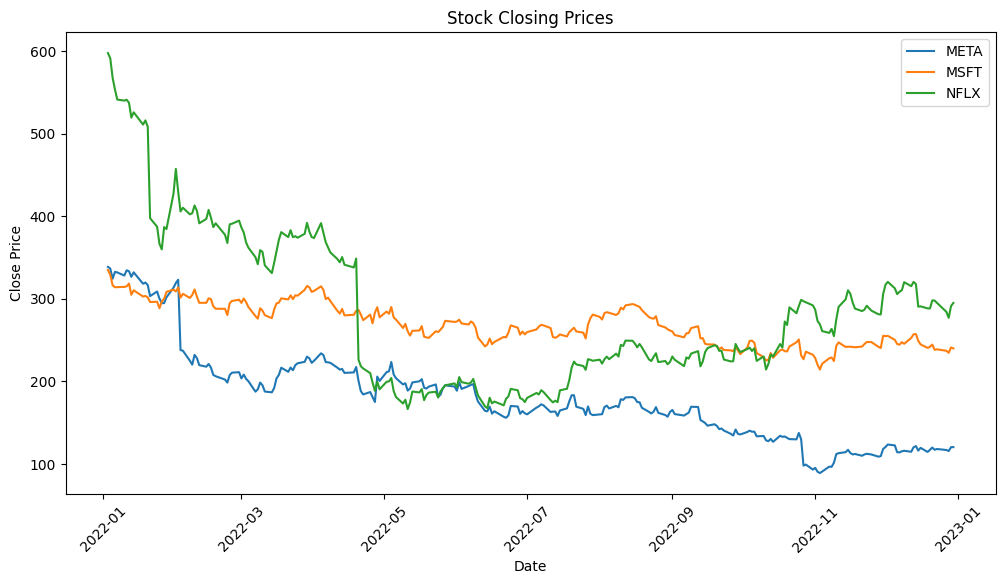

In [11]:
dataframes_forSeen = {name: get_sheet_data(name) for name in sheet_names}
plt.figure(figsize=(12, 6))
for name, df in dataframes_forSeen.items():
    plt.plot(df['Date'], df['Close'], label=name)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Stat Method

In [12]:
def calculate_var(df, confidence_level=95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate VaR at the specified confidence level
    var = np.percentile(df['Return'].dropna(), 100 - confidence_level)
    return var

In [13]:
# Calculating VaR for each stock
for name, df in zip(sheet_names, dataframes):
    var = calculate_var(df)
    print(f"VaR at 95% confidence level for {name}: {var*100:.2f}%")

VaR at 95% confidence level for META: -5.87%
VaR at 95% confidence level for MSFT: -3.85%
VaR at 95% confidence level for NFLX: -5.53%


Historical

In [ ]:
# Function to calculate VaR by finding the greatest loss
def calculate_VaR_simple_loss(df):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Find the greatest loss (minimum return)
    greatest_loss = df['Return'].min()
    return greatest_loss

In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_simple_loss(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -26.39%
VaR (greatest loss) for MSFT: -7.72%
VaR (greatest loss) for NFLX: -35.12%


Monte Carlo

Sample Random Simulation pi

In [ ]:
num_simulations = 10000
num_days = 252
initial_investment = 100000
confidence_level = 0.95
mean_return = 0.12
volatility = 0.3

In [ ]:
def calculate_stock_returns(initial_value, final_value, days=365):
    """
    Calculate the annual and daily returns of a stock.

    :param initial_value: The initial value of the stock.
    :param final_value: The final value of the stock after a period.
    :param days: The number of days over which the final value is measured. Default is 365 for one year.
    :return: A tuple containing the annual return and daily return as percentages.
    """
    # Calculate annual return
    annual_return = ((final_value - initial_value) / initial_value) * 100

    # Calculate daily return based on the number of days
    daily_return = ((final_value / initial_value) ** (1/days) - 1) * 100

    return annual_return, daily_return

In [ ]:
def estimate_pi(num_samples):
    inside_circle = 0

    for _ in range(num_samples):
        x, y = random.uniform(0, 1), random.uniform(0, 1)
        distance = x**2 + y**2
        if distance <= 1:
            inside_circle += 1

    pi_estimate = 4 * inside_circle / num_samples
    return pi_estimate

In [ ]:
pi_estimate = estimate_pi(100000)
print(f"Estimated π: {pi_estimate}")

Estimated π: 3.12884


In [ ]:
portfolio_values = []
for _ in range(num_simulations):
    daily_returns = np.random.normal(mean_return / num_days, volatility / np.sqrt(num_days), num_days)
    portfolio_value = initial_investment * np.prod(1 + daily_returns)
    portfolio_values.append(portfolio_value)

In [ ]:
portfolio_values = np.array(portfolio_values)
VaR = np.percentile(portfolio_values, (1 - confidence_level) * 100)
VaR_loss = initial_investment - VaR

print(f"Estimated VaR at {confidence_level*100}% confidence level: ${VaR_loss:.2f}")

Estimated VaR at 95.0% confidence level: $34391.49


Combine